In [2]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt  
import random as rng
rng.seed(12345)
import os

In [3]:
# iscrtavanje slika i plotova unutar samog browsera
%matplotlib inline 
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 16,12

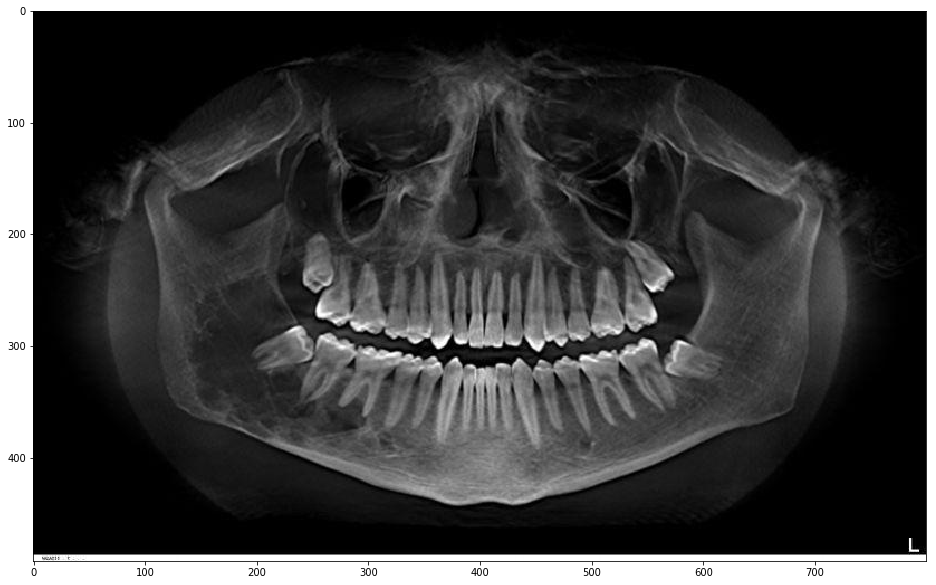

In [4]:
img = cv2.imread('XRay.jpg') 
#img = cv2.resize(img,(800,493))
plt.imshow(img,'gray')

In [5]:
h, w = img.shape[:2]

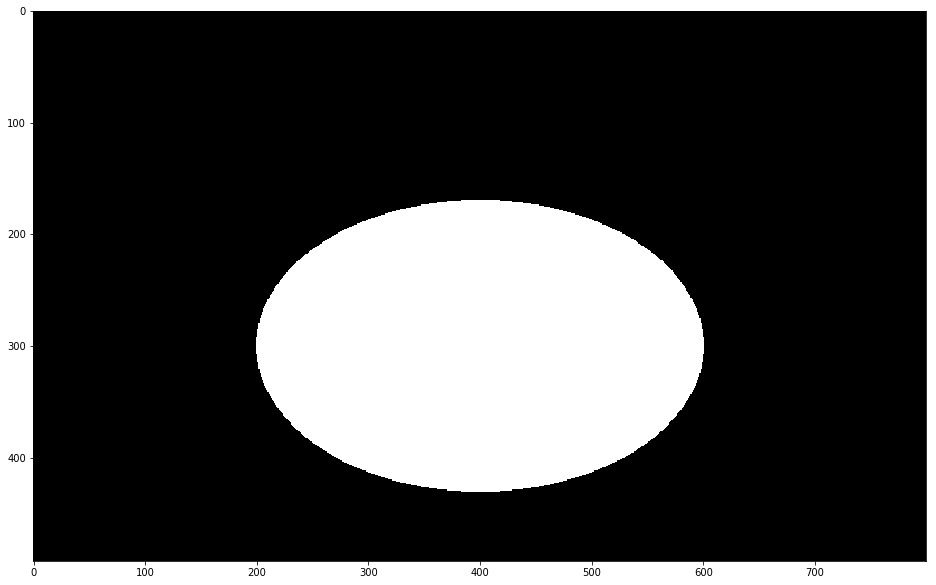

In [6]:
blank_image = np.zeros((h,w,3), np.uint8)
cv2.ellipse(blank_image,(400,300),(200,130),0,0,360,[255,255,255],-1)
plt.imshow(blank_image)  

#blank_image = np.zeros((h,w,3), np.uint8)
#cv2.ellipse(blank_image,(1150,700),(700,400),0,0,360,[255,255,255],-1)
#plt.imshow(blank_image)  

#blank_image = np.zeros((h,w,3), np.uint8) 
#blank_image[:,0:w] = (200,200,200) 
#cv2.ellipse(blank_image,(400,300),(250,150),0,0,360,[255,255,255],-1) 
#plt.imshow(blank_image)

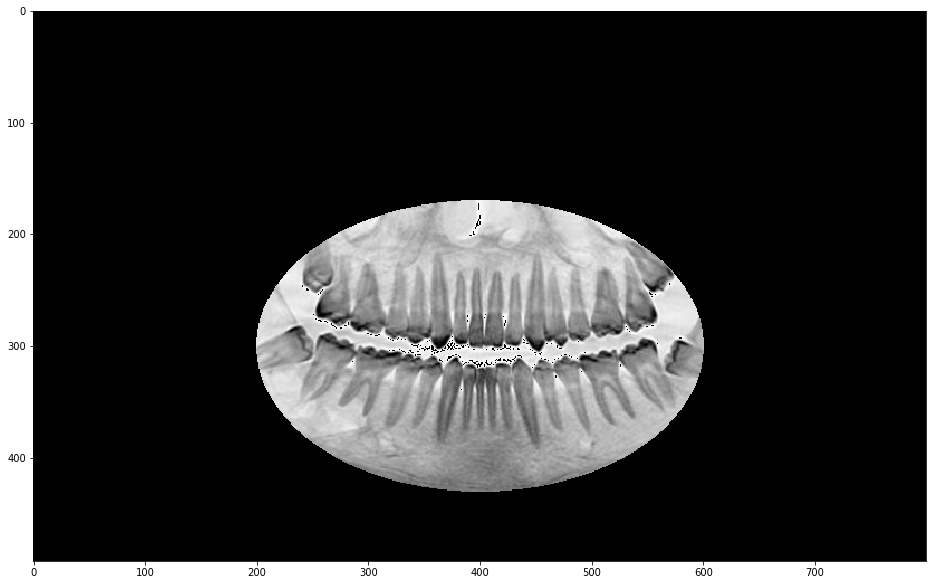

In [8]:
nova=img*blank_image
plt.imshow(nova)  

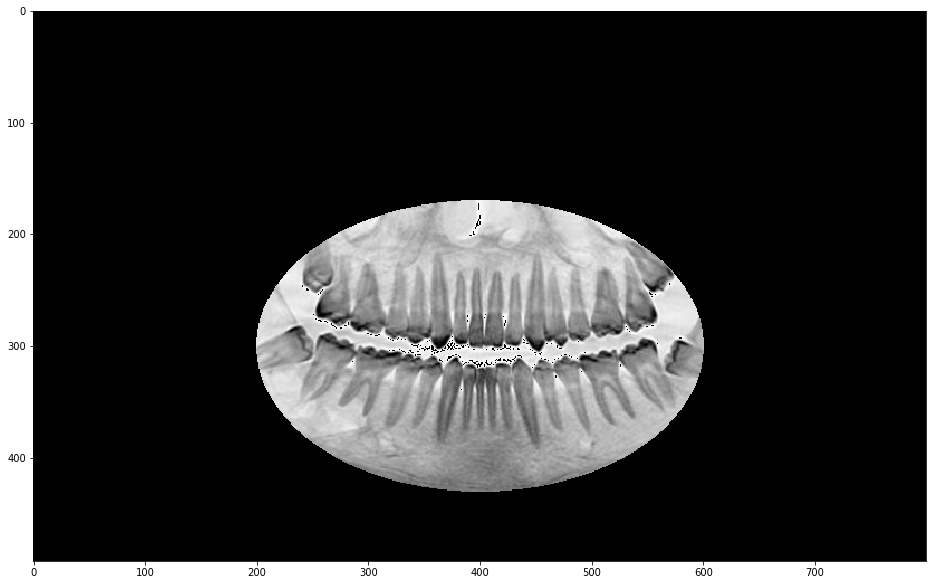

In [9]:
ret,invbin = cv2.threshold(nova,150,1,cv2.THRESH_BINARY)

plt.imshow(nova)


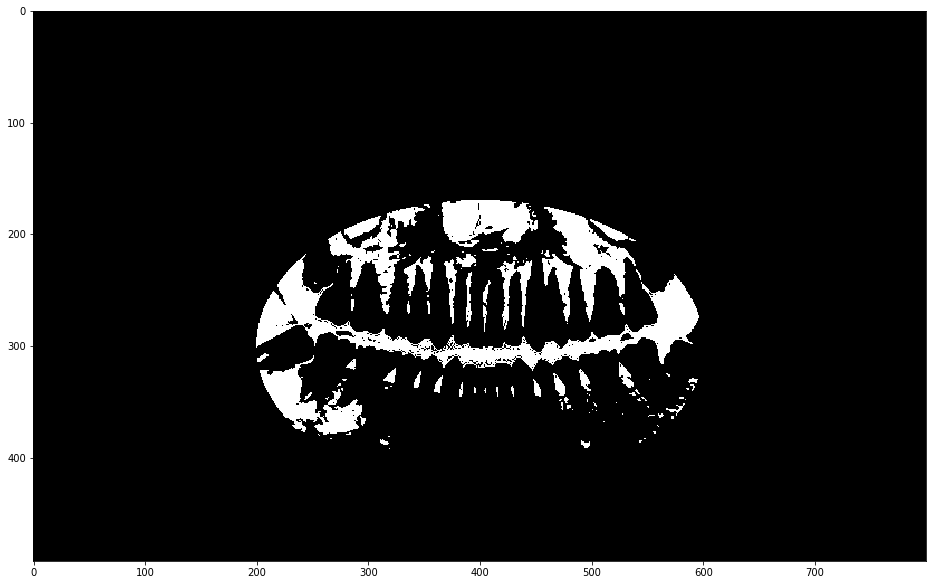

In [10]:
#nova[np.all(nova <170, axis=2)] = 1
ret,nova = cv2.threshold(nova,200,255,cv2.THRESH_BINARY)
plt.imshow(nova)  

True

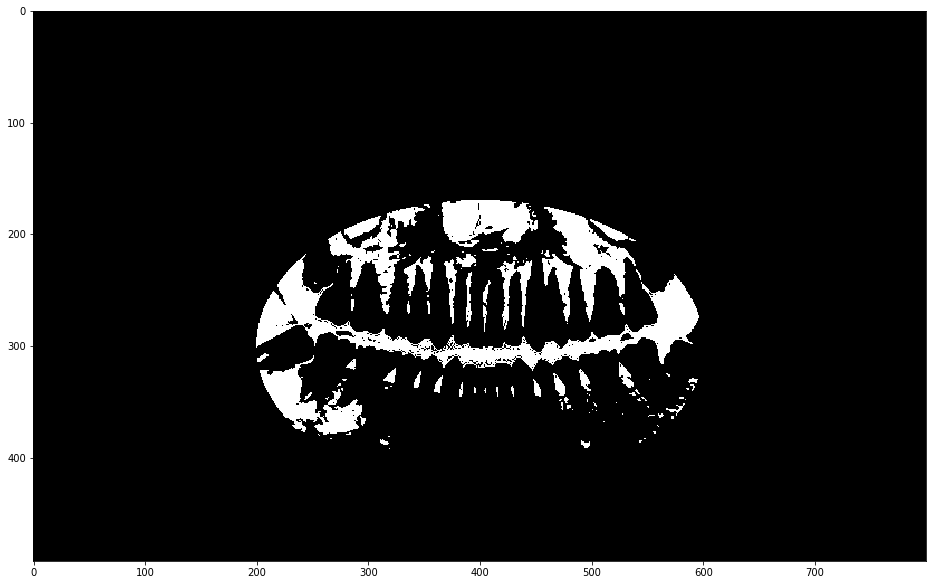

In [11]:
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv2.filter2D(nova, cv2.CV_32F, kernel)
sharp = np.float32(nova)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
#cv.imshow('Laplace Filtered Image', imgLaplacian)
plt.imshow(imgResult) 
cv2.imwrite('binarna.jpg',imgResult)

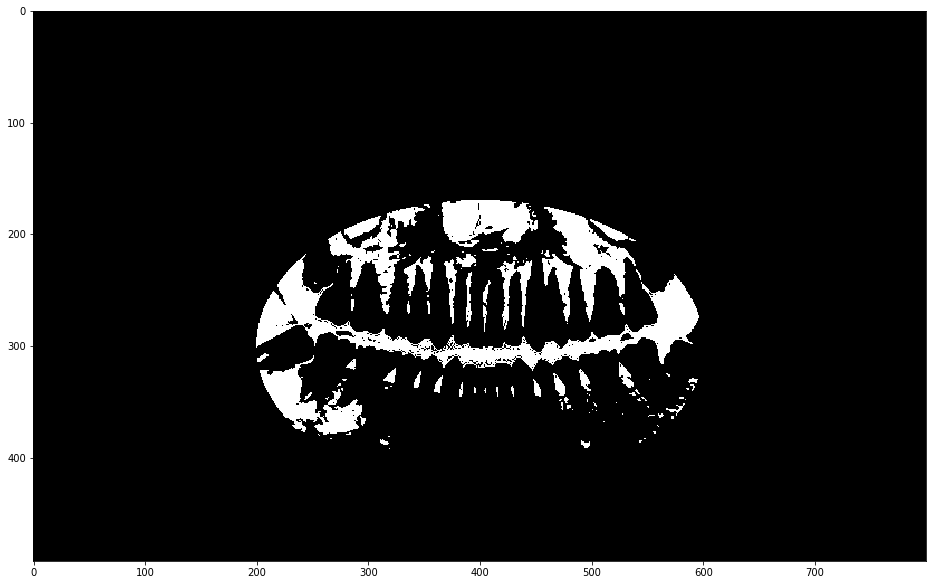

In [12]:
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
#bw = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 17)
#bw=cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 57, 27) ovaj je bio dobar
bw=cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 127, 0)
plt.imshow(bw, 'gray') 
#cv2.imwrite('binarna.png',img)

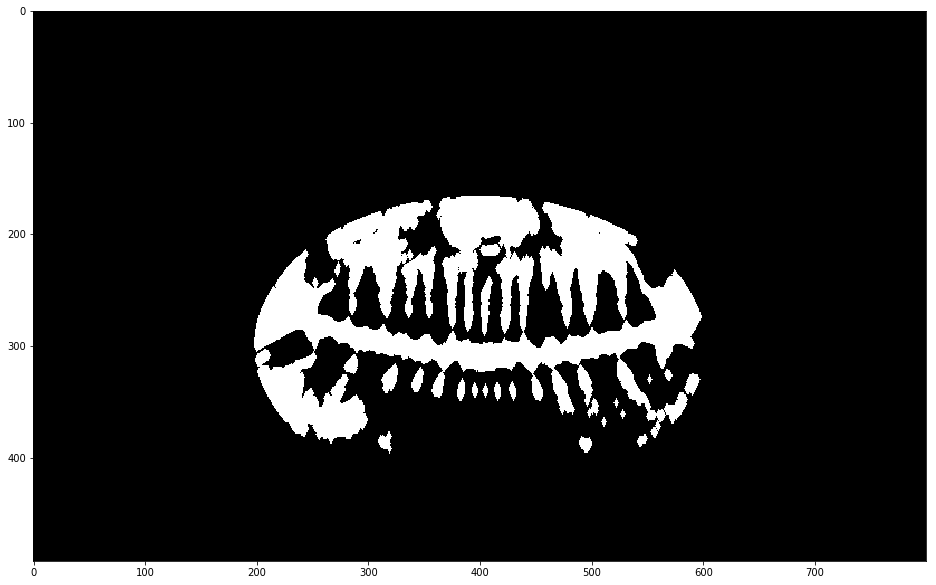

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,5))
img_dil = cv2.dilate(bw, kernel, iterations=2)
#img_close = cv2.erode(img_dil, kernel, iterations=3)
#Ubaciti da oboji supljine
#Videti da li OCR moze da rotirra slike 
plt.imshow(img_dil, 'gray')

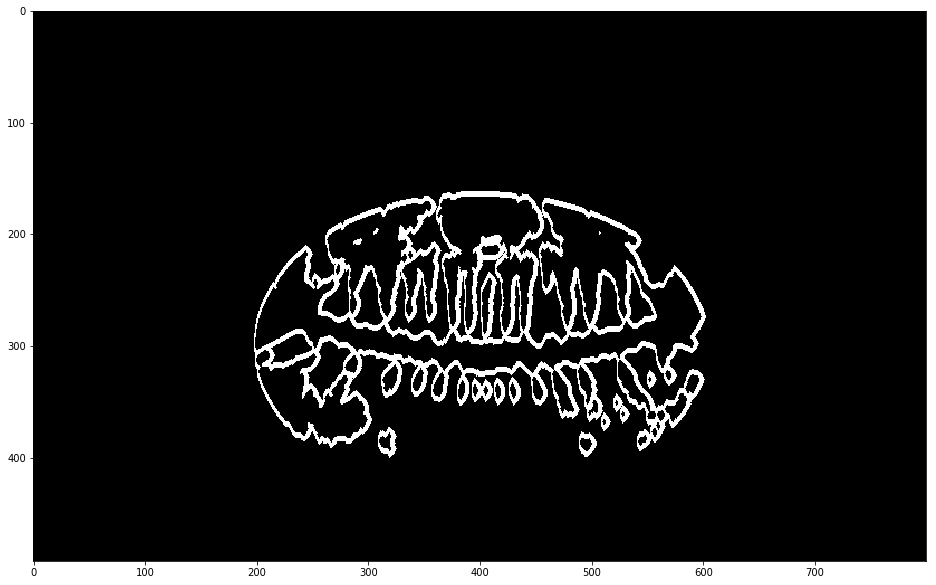

In [14]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 3))
image_edges = cv2.dilate(img_dil, kernel, iterations=4) - cv2.erode(img_dil, kernel, iterations=1)
plt.imshow(image_edges, 'gray')

[[0 1]
 [1 1]
 [0 1]]


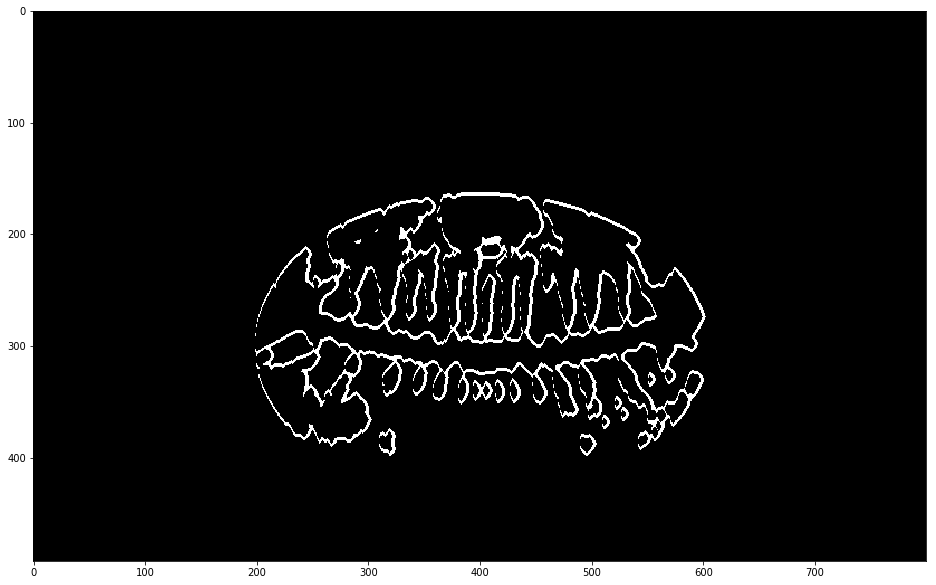

In [15]:
# drugaciji strukturni element
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,3)) # MORPH_ELIPSE, MORPH_RECT...
print(kernel)
er=cv2.erode(image_edges, kernel, iterations=1)
plt.imshow(er, 'gray') # 5 iteracija

[[1.]
 [1.]
 [1.]
 [1.]]


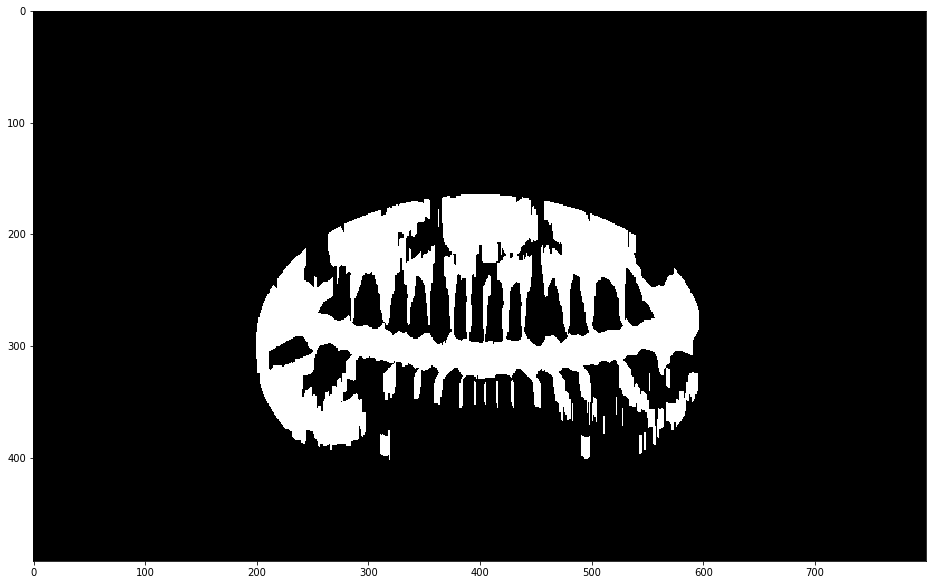

In [16]:
# drugaciji strukturni element
#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (4,4)) # MORPH_ELIPSE, MORPH_RECT...
kernel=np.ones((4,1))
print(kernel)
pom1=cv2.dilate(bw, kernel, iterations=5)
plt.imshow(pom1, 'gray') # 5 iteracija

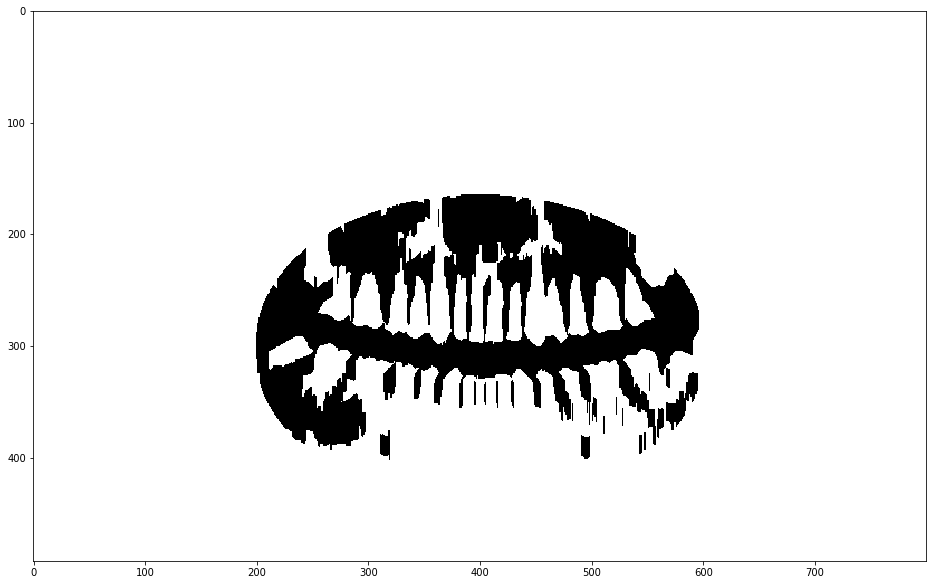

In [17]:
pom2 = 255 - pom1  # ako su pikeli u intervalu [0,255] ovo je ok, a ako su u intervalu [0.,1.] onda bi bilo 1. - img
plt.imshow(pom2, 'gray')

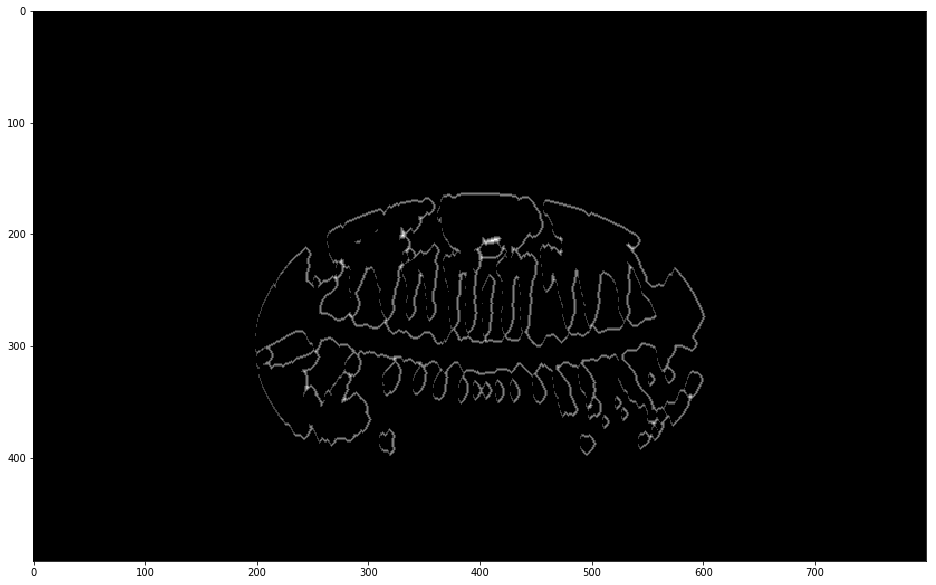

In [18]:
# Perform the distance transform algorithm
dist = cv2.distanceTransform(er, cv2.DIST_L1, 0)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
#dist = cv2.distanceTransform(pom, cv2.DIST_L1, 0)
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.imshow(dist, 'gray') # 5 iteracija

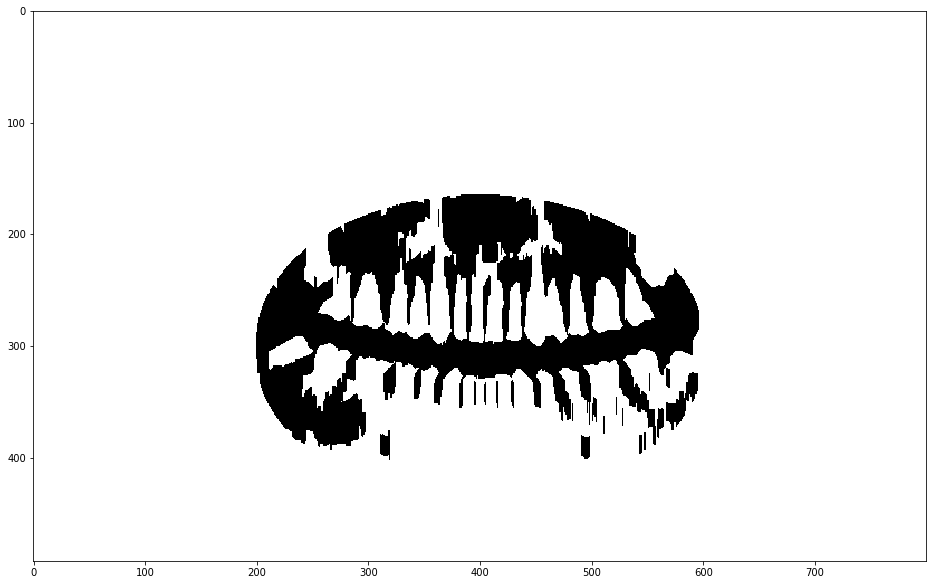

In [19]:
dist2 = cv2.normalize(pom2, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
ret, sure_foreground = cv2.threshold(dist2, 0, int(pom1.max()), cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(dist2, 'gray')

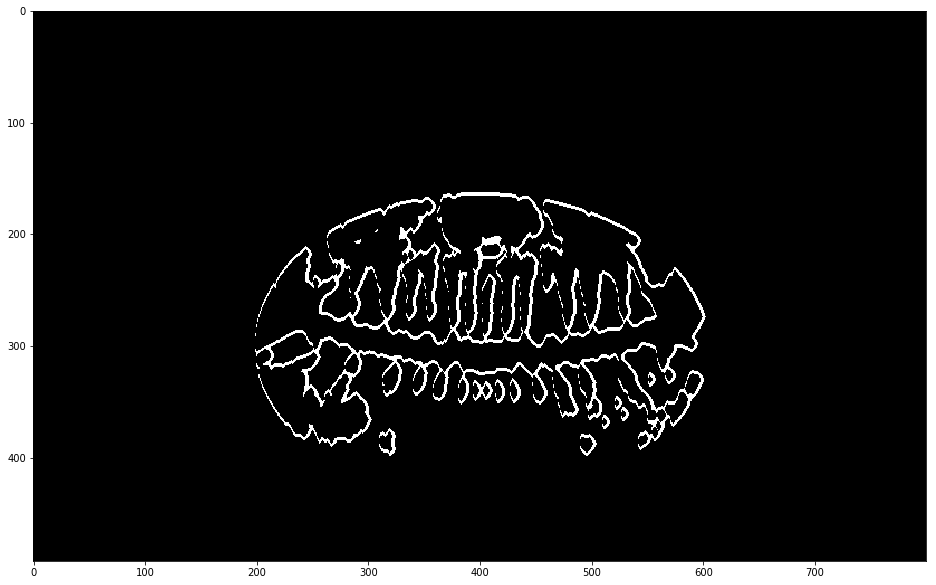

In [20]:
_, dist = cv2.threshold(dist, 0.1, 1.0, cv2.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((1,1), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.imshow(dist, 'gray')

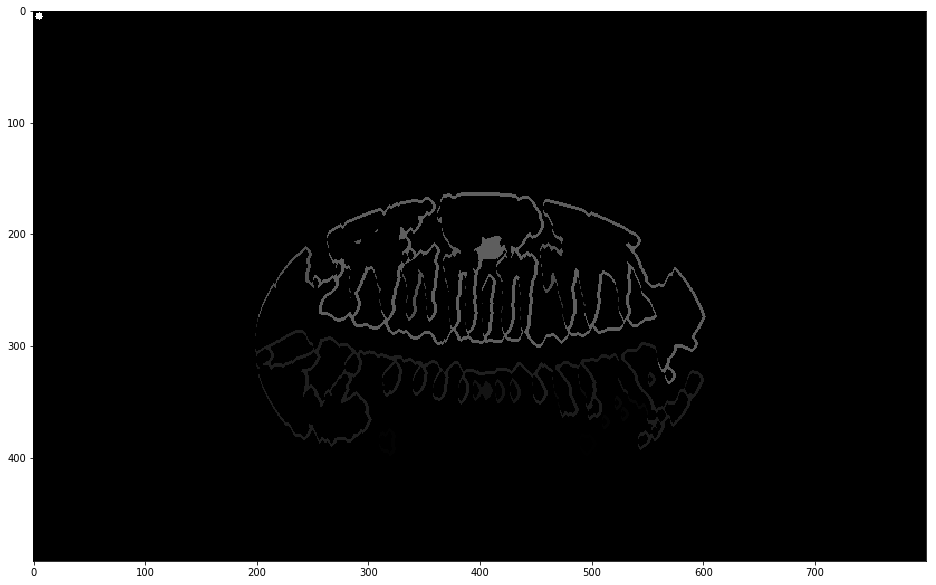

In [21]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
_, contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
plt.imshow(markers*10000, 'gray')

True

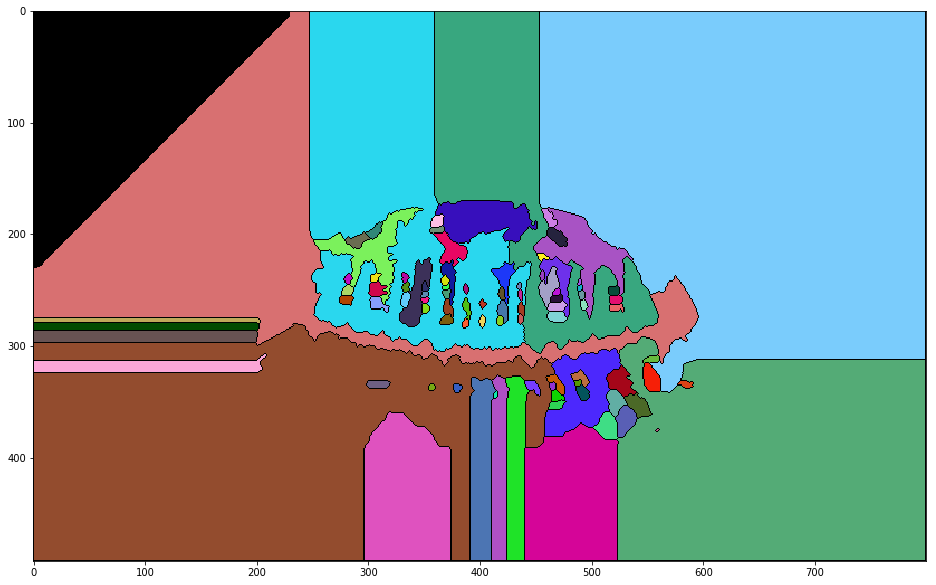

In [22]:
# Perform the watershed algorithm
cv2.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []

for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.imshow(dst, 'gray')
cv2.imwrite('watershed.jpg',dist)

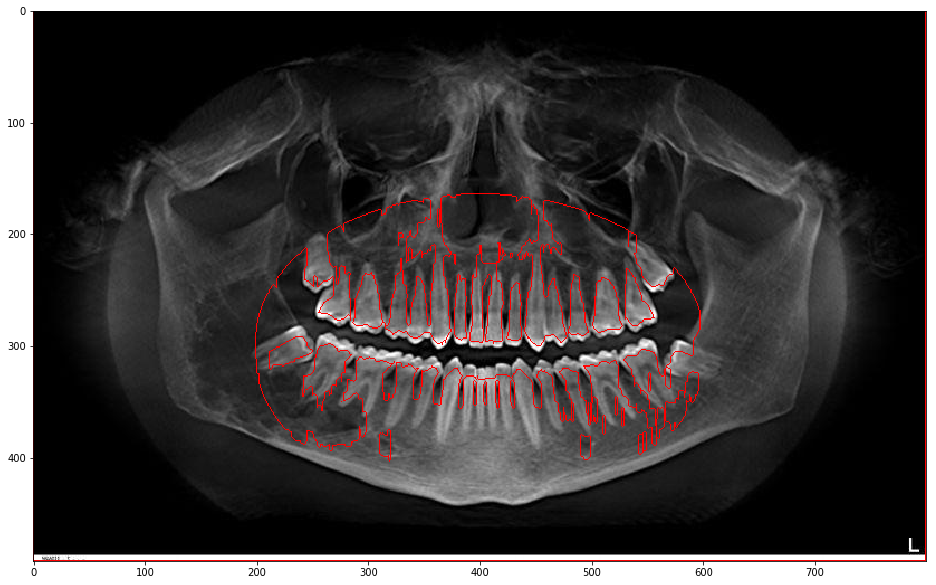

In [23]:
_,contours, hierarchy = cv2.findContours(pom2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

img1 = img.copy()
cv2.drawContours(img1, contours, -1, (255, 0, 0), 1)
plt.imshow(img1)

True

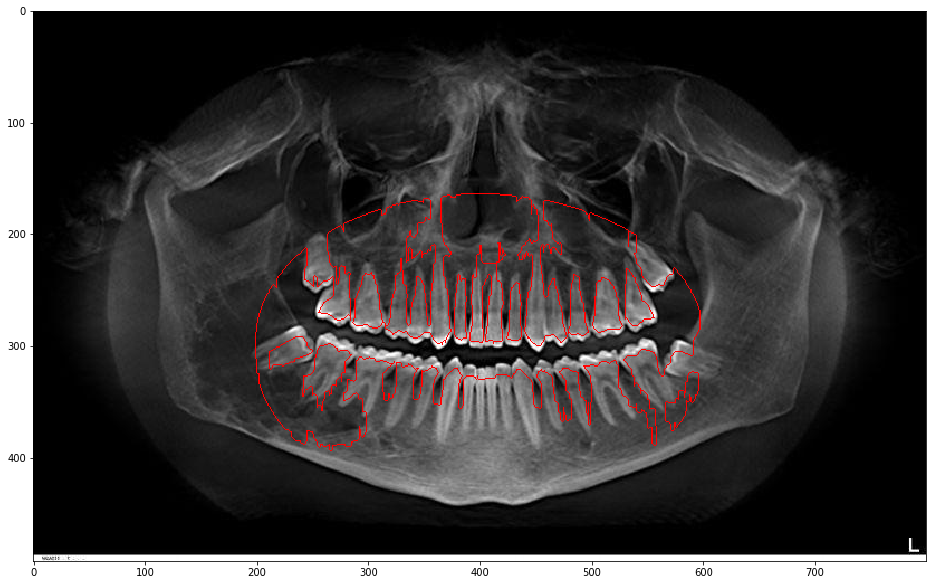

In [24]:
contours_barcode = [] #ovde ce biti samo konture koje pripadaju bar-kodu
for contour in contours: # za svaku konturu
    center, size, angle = cv2.minAreaRect(contour) # pronadji pravougaonik minimalne povrsine koji ce obuhvatiti celu konturu
    width, height = size
    if width > 10 and width < 400 and height > 10 and height < 400: # uslov da kontura pripada bar-kodu
        contours_barcode.append(contour) # ova kontura pripada bar-kodu

img1 = img.copy()
cv2.drawContours(img1, contours_barcode, -1, (255, 0, 0), 1)
plt.imshow(img1)
cv2.imwrite('contours.jpg',dist)